## Modelling Mathematical Theorems
### Goals
* Determine if there is a trend among theorems of similar fields of Mathematics
* What are the most similar fields of Mathematics
* Build a predictive model to determine a field by commonly used words

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib2 import Request, urlopen, HTTPError
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import PorterStemmer
from urlparse import urlunparse, urlparse
from nltk.corpus import wordnet as wn
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import scipy.stats as stat
from nltk import corpus
import plasTeX as tex                                             # For Parsing TeX in Wikipedia 
import requests_cache
import pandas as pd
import scipy as sci
import numpy as np
import wordcloud
import nltk
import json 
import re

%matplotlib inline
plt.style.use('ggplot')
requests_cache.install_cache('coll_cache')

In [65]:
from IPython.core.display import display, HTML
display(HTML('https://en.wikipedia.org/wiki/List_of_theorems'))

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_theorems'
html = urlopen(url)
soup = BeautifulSoup(html,'html.parser')
sections = soup.find_all('li')
sections = sections[37:1152] # Remove Header and Footer

In [3]:
if(True):
    theorems = {'Field':[],'Title':[],'Link':[],'Page':[]}
    for temp in sections:
        link = temp.find('a')
        cat = temp.find('i')
        if (cat == None):
            if (re.search(r'\(.*?\)',link.get('title')) == None):
                cat = ''
            else:
                cat = re.sub('\(|\)','',re.search(r'\(.*?\)',link.get('title')).group())
        else:
            cat = cat.get_text().lower()

        try:
            html = urlopen("https://en.wikipedia.org"+str(link.get('href')))
            page = BeautifulSoup(html,'html.parser')
        except HTTPError as e:  
            page = e

        theorems['Field'].append(cat)
        theorems['Title'].append(link.get('title'))
        theorems['Link'].append(link.get('href'))
        if type(page) == HTTPError:
            theorems['Page'].append(page)
        else:
            theorems['Page'].append(page.find(class_='mw-content-ltr'))
    theorems = pd.DataFrame(theorems)
    theorems.to_csv("theorems.txt",sep=',',encoding='utf-8') # Use encoding because of scaped pages
    print theorems.shape
else:
    ## Easier to just load the saved .csv, rather than re-scrape Wikipedia
    theorems = pd.read_csv('theorems.txt',sep = ',',encoding = 'utf-8',index_col=0)
    theorems['Page'].replace({x:BeautifulSoup(x,'html.parser') for x in theorems['Page']},inplace = True)
    print theorems.shape

(1115, 4)


In [60]:
## Clean up the table (get rid of Unicode titles)
for field in theorems['Field']:
    try:
        str(field)
    except UnicodeEncodeError as e:
        print field
theorems['Field'][['quantum theory' in x for x in theorems['Field']]] = 'quantum theory'
theorems['Field'][['clebsch' in x for x in theorems['Field']]] = 'clebsch gordan coefficients'
theorems['Field'] = [str(x) for x in theorems['Field']]

## Removes Theorems in Categories with only min_cnt entries
min_cnt = 4
good_fields = list(theorems.groupby('Field').count()[theorems.groupby('Field').count()['Link'] > min_cnt].index) 
duplicate_theorems = theorems[[(x in good_fields) for x in theorems['Field']]]
n = duplicate_theorems.shape[0]

In [64]:
trimmed = [" ".join([x for x in page.get_text().split() if re.search('\{*\}|\(*\)|\$*\$|\(|\)|\{|\}',x) == None]) for page in duplicate_theorems['Page']]
duplicate_theorems['Trimmed'] = trimmed
duplicate_theorems

,Field,Link,Page,Title,Trimmed
0,algebraic geometry,/wiki/AF%2BBG_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",AF+BG theorem,"In algebraic geometry, a field of mathematics,..."
1,number theory,/wiki/ATS_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",ATS theorem,"In mathematics, the ATS theorem is the theorem..."
2,combinatorics,/wiki/Abel%27s_binomial_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abel's binomial theorem,This mathematics-related article is a stub. Yo...
3,mathematical analysis,/wiki/Abel%27s_curve_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abel's curve theorem,"In mathematics, the Abel–Jacobi map is a const..."
4,mathematical analysis,/wiki/Abel%27s_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abel's theorem,This article is about Abel's theorem on power ...
5,mathematical analysis,/wiki/Abelian_and_tauberian_theorems,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abelian and tauberian theorems,"In mathematics, abelian and tauberian theorems..."
6,algebraic geometry,/wiki/Abel%E2%80%93Jacobi_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abel–Jacobi theorem,"In mathematics, the Abel–Jacobi map is a const..."
8,algebraic geometry,/wiki/Abhyankar%E2%80%93Moh_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abhyankar–Moh theorem,"In mathematics, the Abhyankar–Moh theorem stat..."
9,geometry,/wiki/Abouabdillah%27s_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abouabdillah's theorem,Abouabdillah's theorem refers to two distinct ...
11,algebraic topology,/wiki/Acyclic_models_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Acyclic models theorem,"In algebraic topology, a discipline within mat..."


In [7]:
stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def remove_small(series,min_len = 3):
    text = []
    [[text.append(y) for y in x.split()] for x in series]
    text = pd.DataFrame({'text':text})
    return(" ".join(text.iloc[[len(x)>min_len for x in text['text']]]['text']))

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text,stopwords=['']):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    #text = remove_small([text],min_len)
    return stem([x for x in tokenize(text) if x.lower() not in stopwords])

def build_wordcloud(text,stopwords,ax=plt,title = ''):
    wordcloud = WordCloud(stopwords = stopwords).generate(text)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.show() if ax == plt else ''
    ax.set_title(title)
    words = WordCloud(stopwords = stopwords).process_text(text)
    words = pd.DataFrame({'Words':words.keys(),'Freq':words.values()}).sort_values('Freq',ascending=0)
    return(words)

def f(text,ax=plt,stopwords=[''],min_len=7): 
    title = text.iloc[0,0]
    texts = [y.lower() for y in text['Trimmed']]
    #texts = [y.lower() for y in text]
    words=build_wordcloud(stopwords=stopwords+title.split(' '),text=remove_small(texts,min_len),ax=ax,title=title)
    return(words)

In [72]:
latexUrl = 'https://en.wikibooks.org/wiki/LaTeX/Command_Glossary'
try:
    latex_html = urlopen(latexUrl)
    soup = BeautifulSoup(latex_html,'html.parser')
except HTTPError as e:  
    print e
tex_words = []
bad_chars = r'[\\|\xc2|\x99|\xa0|{|}]'
for cat in soup.find_all('dl'):
    for word in soup.find_all('dt'):
        try:
            tex_words.append(str(re.sub(bad_chars,'',word.get_text()[1:])).lower())
        except UnicodeEncodeError as e:
            print word
        except IndexError as e:
            print word

stopwords = ['will','the','and','that','said',
             'from','they','their','this','year','ext',
             'mathbb','true','false','displaystyle','wikipedia',
             'ready','user','mediawiki','mw','value','theorem',
             'number','lemma','template','en','k_','cdot','x_',
             'pmod','styles','window','gadget','module','a_','rlq',
             'edit','system','varphi','mathbf','function','wikimedia',
             'scriptstyle','doi','references','mathrm']+tex_words

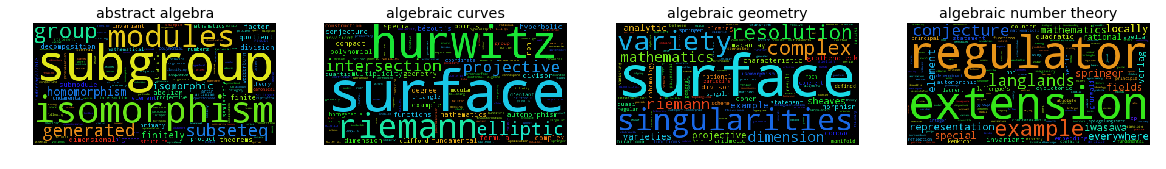

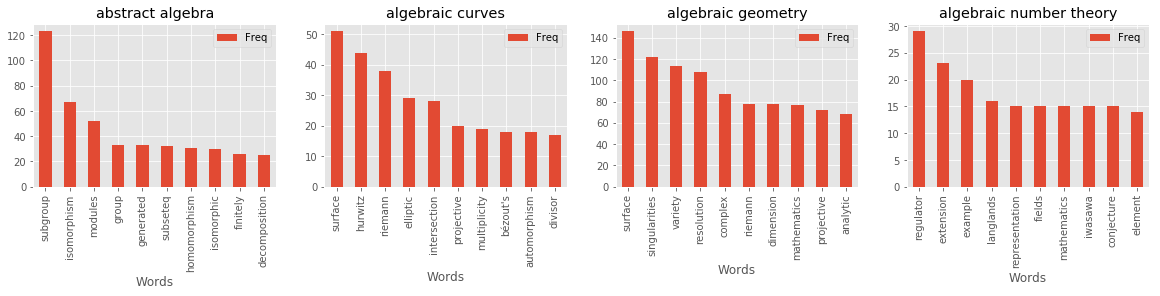

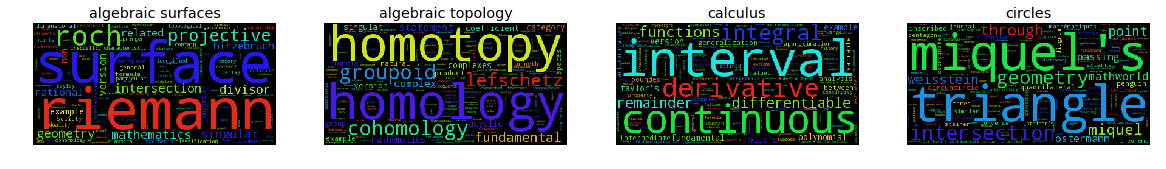

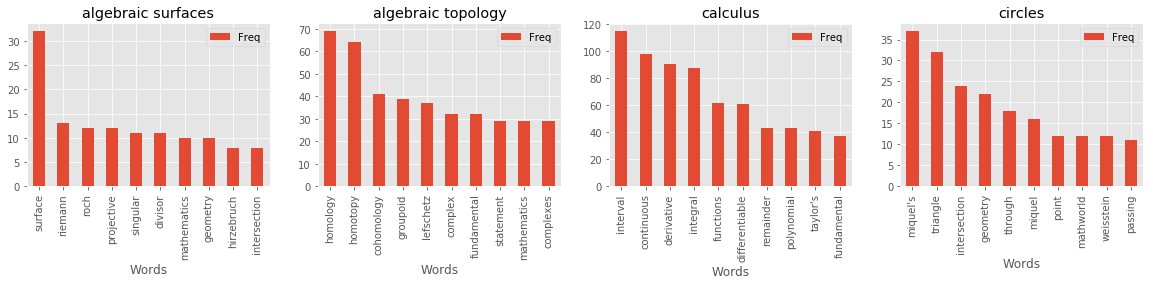

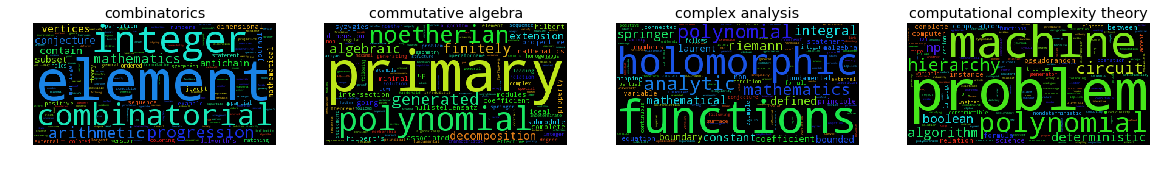

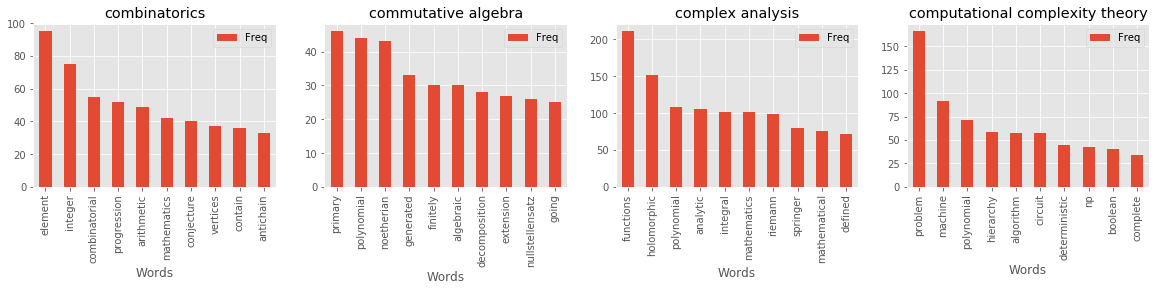

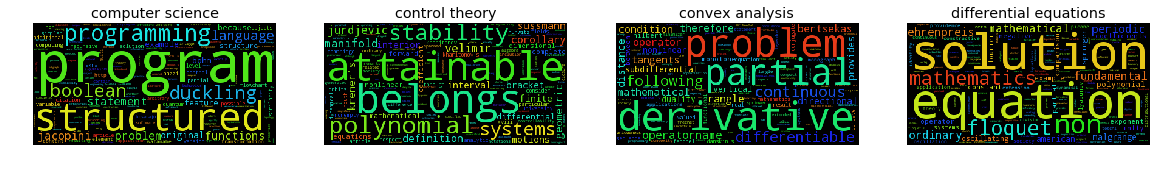

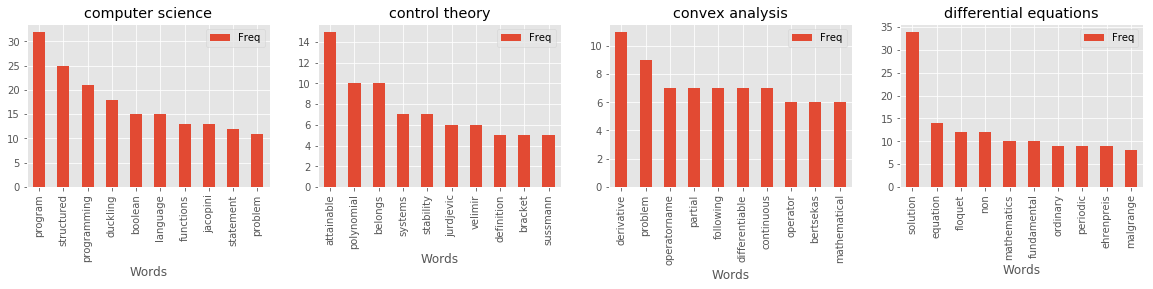

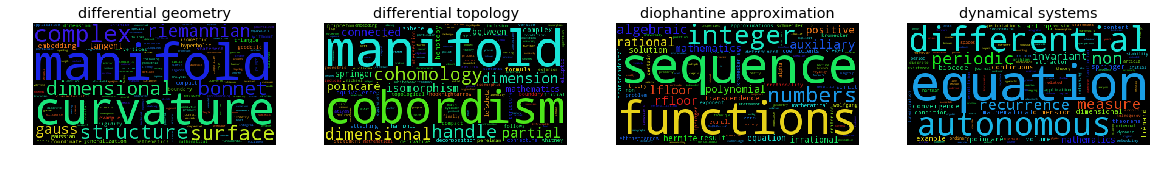

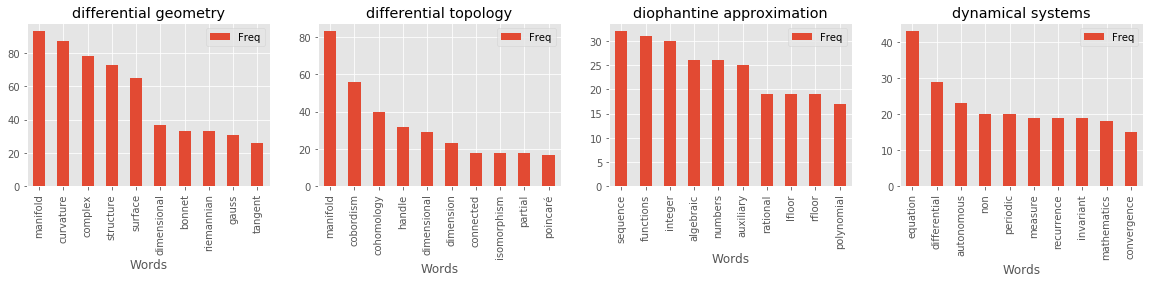

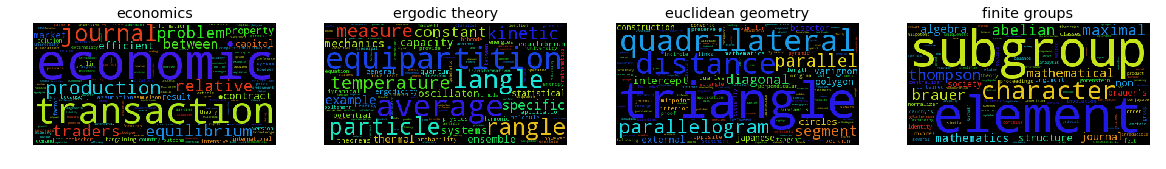

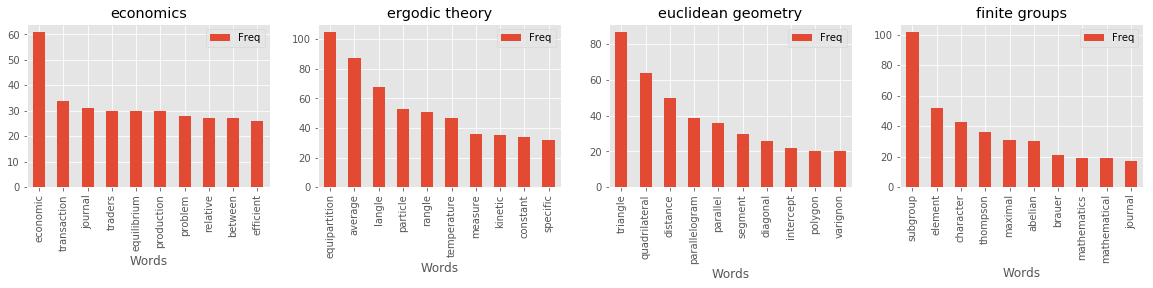

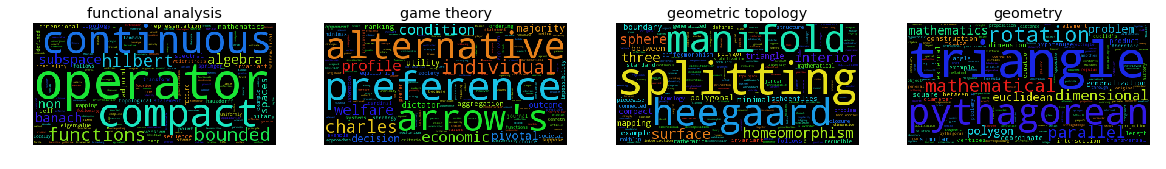

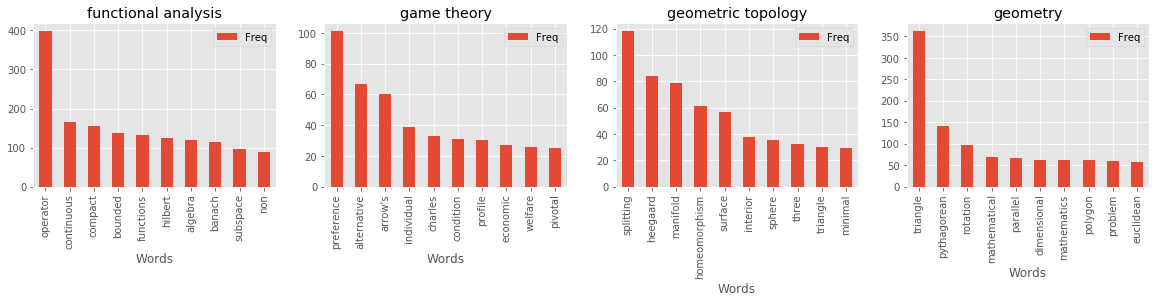

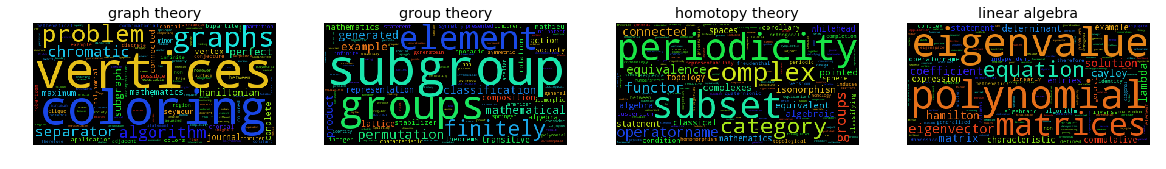

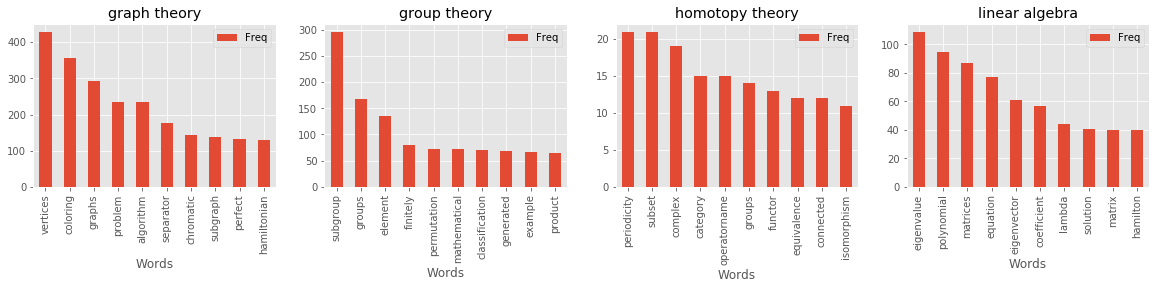

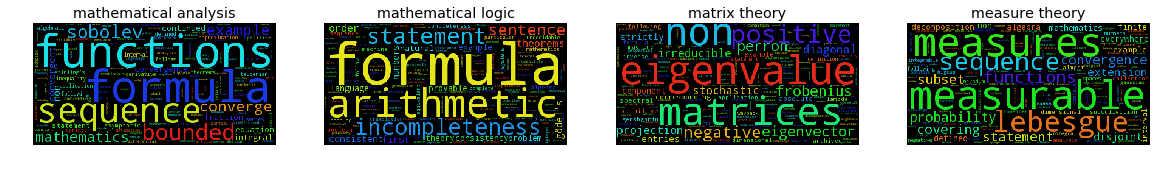

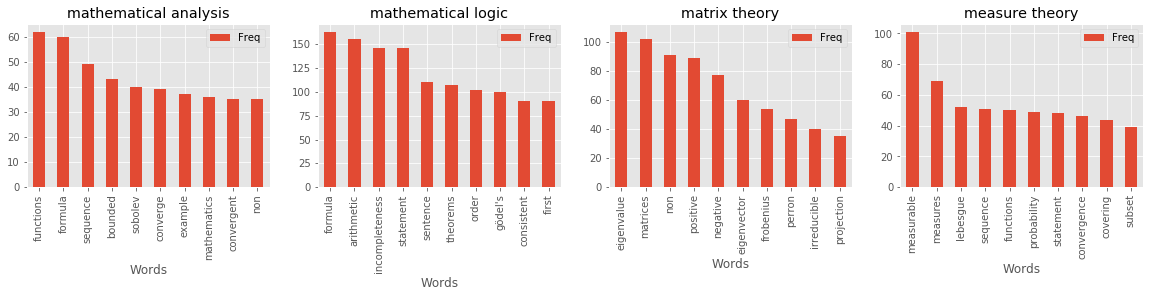

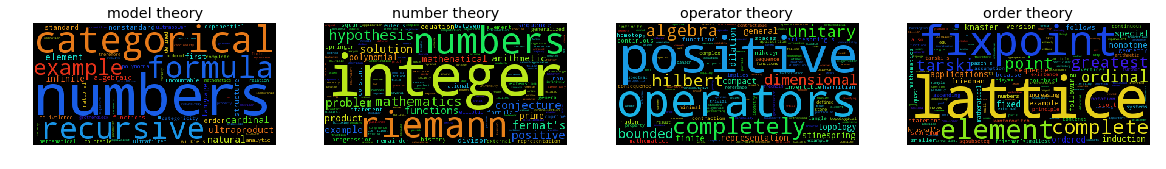

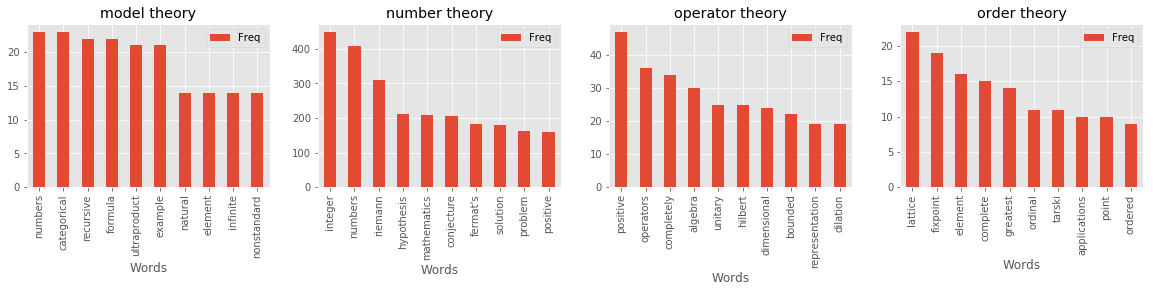

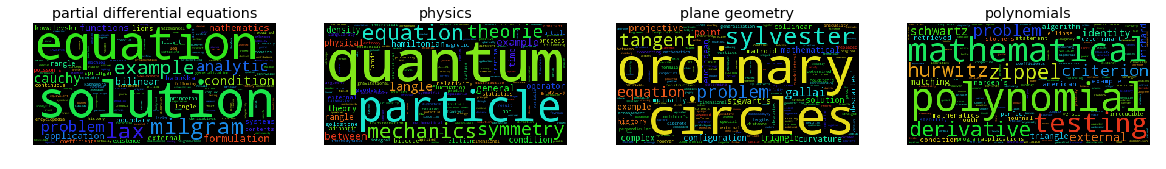

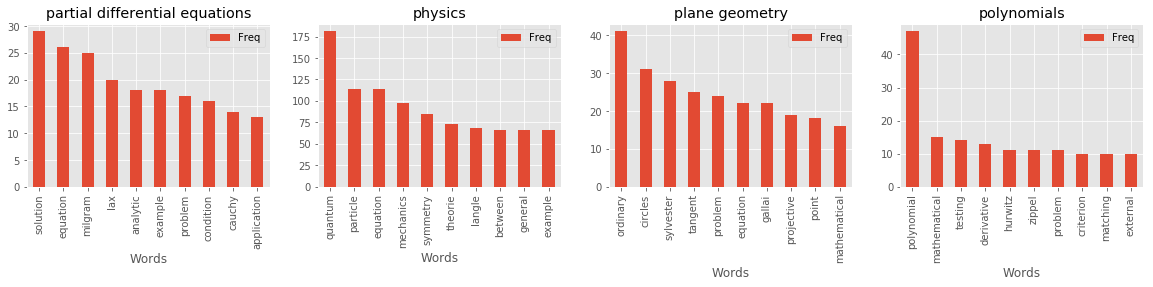

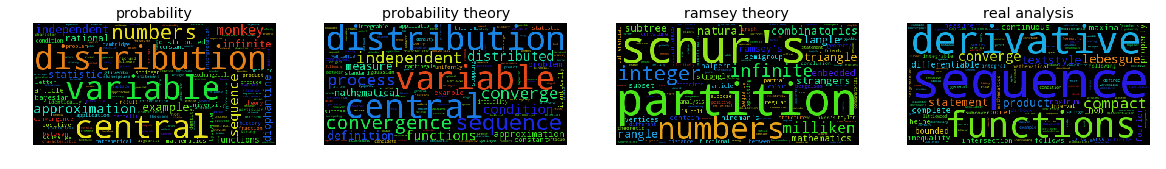

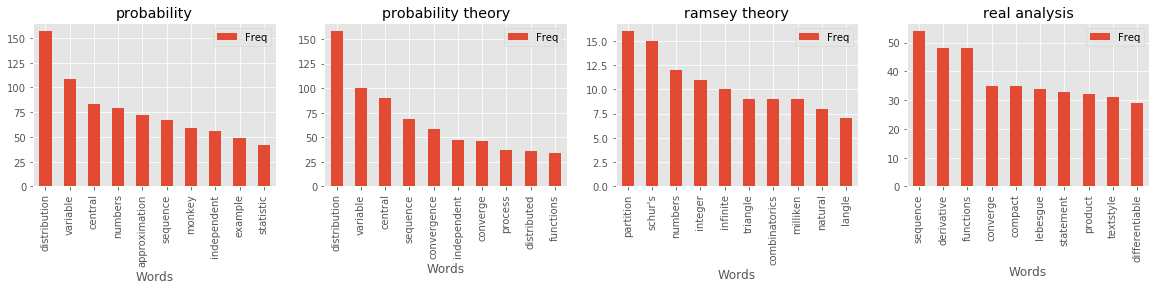

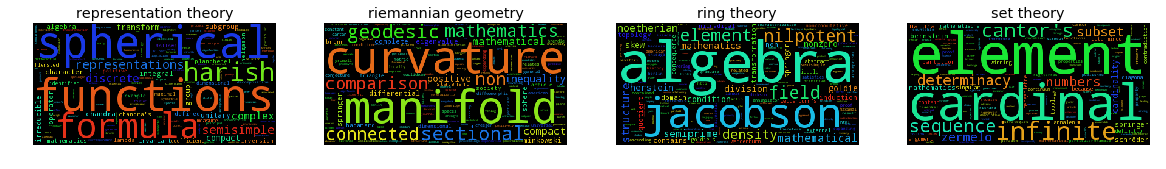

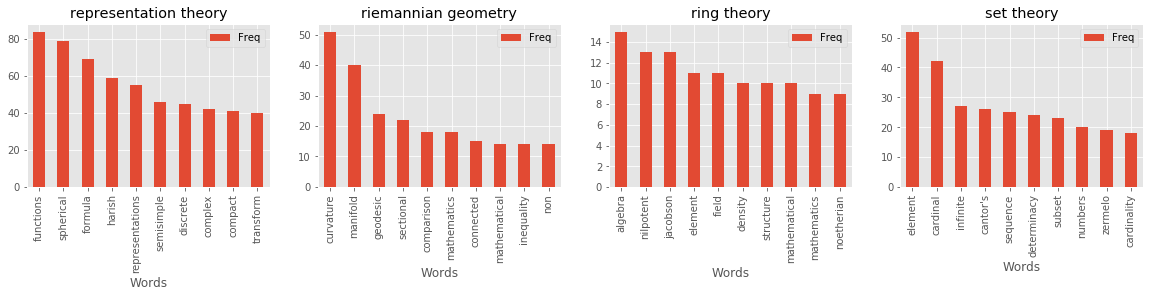

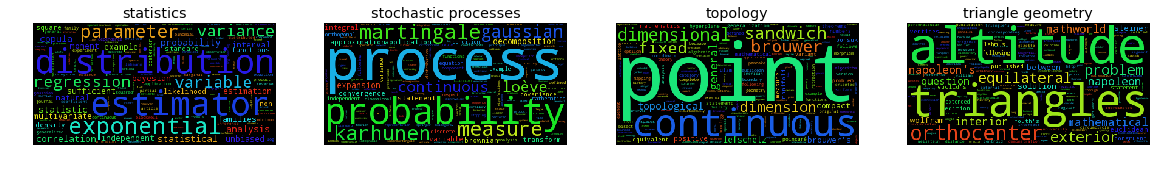

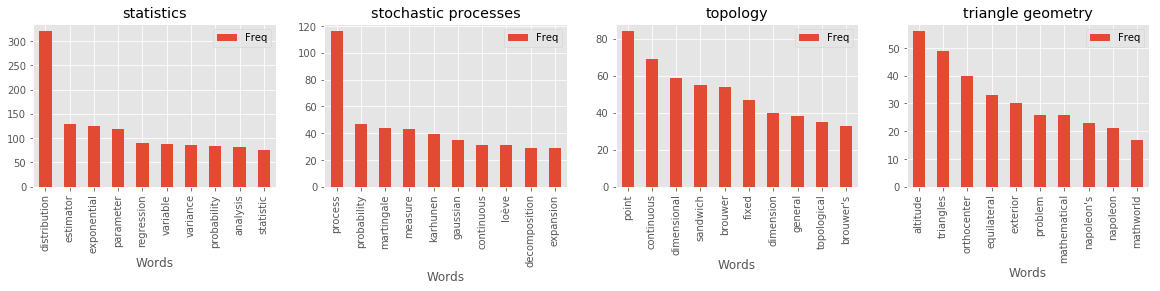

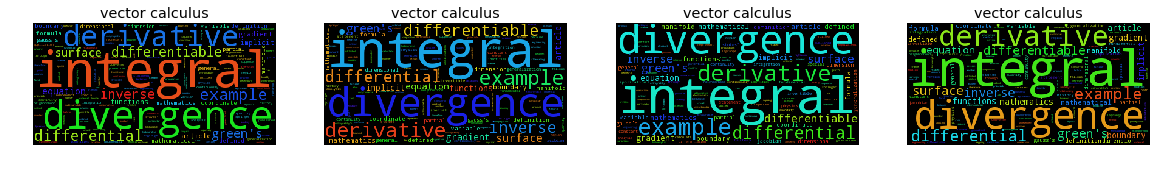

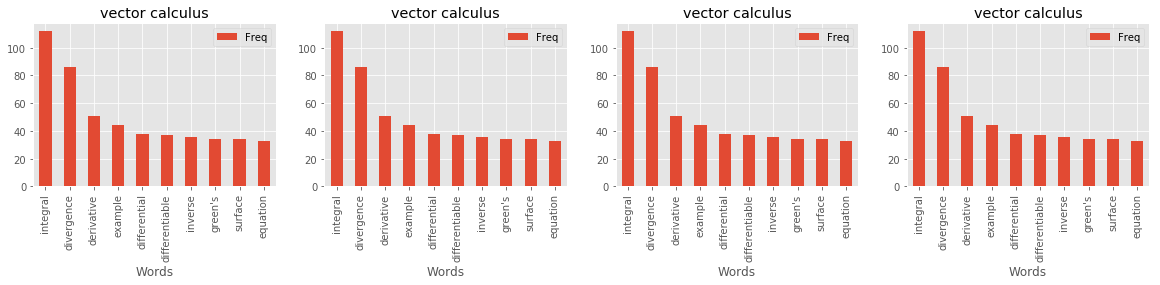

In [73]:
min_len = 6
grp = duplicate_theorems.groupby('Field')
fields = grp.apply(lambda x: x.iloc[0,0])
topwords = {}
for j in range(int(np.ceil(float(len(grp))/4.0))):
#for j in range(3):    
    _,ax1 = plt.subplots(1,4,figsize = [20,10])
    _,ax2 = plt.subplots(1,4,figsize = [20,3])
    for i in xrange(4):
        field = fields[i+4*j] if i+4*j < len(grp) else fields[-1]
        temp = duplicate_theorems[duplicate_theorems['Field']==field]
        txt=f(temp,ax1[i],stopwords=stopwords,min_len=min_len)
        txt[0:10].set_index('Words').plot(kind='bar',ax=ax2[i],title=field)
        topwords[field] = txt
        

Use some kind of mathjax stuff to parse Latex

Look up Wordnet for allowing for phrase identifying

In [57]:
textd = {}                                              # dictionary from lemmata to document ids containing that lemma
min_freq = 5
#for field in fields:  
for field in topwords.keys():
    #t = " ".join(corpus['Trimmed'])
    t = " ".join(topwords[field]['Words'][topwords[field]['Freq'] > min_freq])    
    s = set(lemmatize(t,stopwords))
    try:
        toks = toks | s
    except NameError:
        toks = s
    for tok in s:
        try:
            textd[tok].append(field)
        except KeyError:
            textd[tok] = [field]
textd_save = textd

In [58]:
min_len = 4
textd = {key:vals for key,vals in textd_save.items() if len(key) > min_len}
print len(textd_save.keys()),len(textd.keys())
temp = pd.DataFrame({'Keys':textd.keys(), 'Length':[len(y) for y in textd.values()]}).sort_values('Length',ascending=False)
temp[0:10]

2412 2175


,Keys,Length
1515,mathemat,53
2025,exampl,45
1302,statement,43
543,gener,39
384,applic,38
1089,follow,37
517,springer,36
913,extern,34
832,between,34
67,relat,33


In [14]:
def get_max_sim(C):
    """
    Returns the df of the most similar articles for a given corpus class. 
    Also returns a corpus for that df.
    """
    A = C
    temp = {'Max':[],'Argmax':[]}
    for i in range(A.shape[0]):
        temp['Argmax'].append((A.getcol(i)[range(i)+range(i+1,A.shape[0])]).A.argmax())
        temp['Max'].append((A.getcol(i)[range(i)+range(i+1,A.shape[0])]).max())
    df = pd.DataFrame(temp,index=range(A.shape[0])).sort_values(['Max'],ascending = 0)
    df['Field_1'] = np.array(fields)[df.index.values]
    df['Field_2'] = np.array(fields)[df['Argmax']]
    return(df)

def all_combos(seq):
    s = []
    for i in range(len(seq)):
        for j in range(i+1,len(seq)):
            s = s + [[seq[i],seq[j]]]
    return s

{'Max{Fields per Word}:': 57}


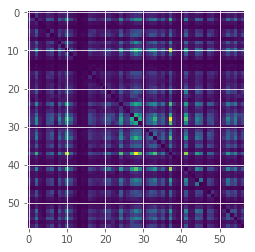

,Argmax,Max,Field_1,Field_2
28,36,266.0,graph theory,model theory
37,28,266.0,number theory,graph theory
10,36,236.0,complex analysis,model theory
41,37,222.0,physics,number theory
29,36,195.0,group theory,model theory
33,36,192.0,mathematical logic,model theory
24,36,190.0,functional analysis,model theory
2,36,172.0,algebraic geometry,model theory
27,36,170.0,geometry,model theory
44,37,153.0,probability,number theory


In [54]:
n = max([len(x) for x in textd.values()])
combos = {}
for i in xrange(n+1):
    combos[i] = all_combos(xrange(i)) 
print {'Max{Fields per Word}:': n}

sim = np.zeros([len(fields),len(fields)])
field_key = {x[1]:x[0] for x in enumerate(fields)}

for key,val in textd.items():
    s = combos[len(val)]
    for indx in s:
        sim[field_key[val[indx[0]]],field_key[val[indx[1]]]] += 1
        sim[field_key[val[indx[1]]],field_key[val[indx[0]]]] += 1

plt.imshow(sim)
plt.show()
max_sim = get_max_sim(sci.sparse.csr_matrix(sim))
max_sim[0:10]

Maybe compare conjectures too at https://en.wikipedia.org/wiki/List_of_conjectures

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import random

def performance(true, pred,P=1):
    TP = FP = TN = FN = 0
    for x,y in zip(true,pred): 
        if x==y==P:
           TP += 1
        if y==P and x!=y:
           FP += 1
        if y!=P and x==y:
           TN += 1
        if y!=P and x!=y:
           FN += 1

    return(TP, FP, TN, FN)

def test_clf(df,clf,topwords,top_x=15):
    if topwords != None:
        df.data = [" ".join(topwords[field]['Words'][0:top_x].values) for field in df.target_names]
    
    indx = range(df.shape[0])
    random.shuffle(indx)
    trainSz = int(np.floor(0.5*len(indx)))
    train_indx, test_indx = indx[:trainSz],indx[trainSz:]
    train_thm, test_thm = df.iloc[train_indx,:], df.iloc[test_indx,:]

    import sklearn.datasets
    train = sklearn.datasets.base.Bunch(
                    description=train_thm.description,
                    filenames=train_thm.filenames,
                    target_names=train_thm.target_names,
                    data=train_thm.data,
                    target=train_thm.target)

    test = sklearn.datasets.base.Bunch(
                    description=test_thm.description,
                    filenames=test_thm.filenames,
                    target_names=test_thm.target_names,
                    data=test_thm.data,
                    target=test_thm.target)

    clf = clf.fit(train.data, train.target)
    predicted = clf.predict(test.data)

    TP, FP, TN, FN = np.mean([performance(test.target, predicted,2) for i in set(predicted)],axis=0)
    acc = np.mean(predicted == test.target)    
    sens = TP/(TP+FN) if TP+FN > 0 else float('Inf')
    spec = TN/(FP+TN) if FP+TN > 0 else float('Inf')
    prec = TP/(TP+FP) if TP+FP > 0 else float('Inf')
    cm = {'Accuracy':acc,'Sensitivity':sens,
          'Specificity':spec,'Precision':prec}
    return(cm)

NB  = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
])
SVM = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42)),
])
new_duplicate = duplicate_theorems.iloc[range(37)+range(38,duplicate_theorems.shape[0]),:].copy()
new_duplicate['target'] = [field_key[x] for x in new_duplicate.Field]
new_duplicate.columns = ['target_names','filenames','Page','description','data','target']

### Fitting Models to Bag of Words

In [75]:
temp = test_clf(new_duplicate,NB,None)
print 'MNB:',{x:round(y,4) for x,y in temp.items()}

svm_cm = test_clf(new_duplicate,SVM,None)
print 'SVM:',{x:round(y,4) for x,y in svm_cm.items()}

grid_svm = {'alpha':[],'n_iter':[],'rand_state':[] ,'Accuracy':[],'Precision':[],'Sensitivity':[],'Specificity':[]}
for alpha in [1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2]:
    for n_iter in [3,8,13,18,23,28,33]:
        for rnd in [20,40,60,80]:
            SVM = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=alpha, n_iter=n_iter, random_state=rnd)),
            ])
            temp1 = test_clf(new_duplicate,SVM,None)
            grid_svm['alpha'].append(alpha)
            grid_svm['n_iter'].append(n_iter)
            grid_svm['rand_state'].append(rnd)            
            grid_svm['Accuracy'].append(temp1['Accuracy'])
            grid_svm['Precision'].append(temp1['Precision'])
            grid_svm['Sensitivity'].append(temp1['Sensitivity'])
            grid_svm['Specificity'].append(temp1['Specificity'])

MNB: {'Sensitivity': 0.0032, 'Accuracy': 0.2415, 'Precision': 0.5, 'Specificity': 0.99}
SVM: {'Sensitivity': 0.0545, 'Accuracy': 0.4903, 'Precision': 0.8, 'Specificity': 0.9845}


{'Best Random State': 60.0, 'Best Alpha': 9.9999999999999998e-13, 'Best Num Iter': 13.0}


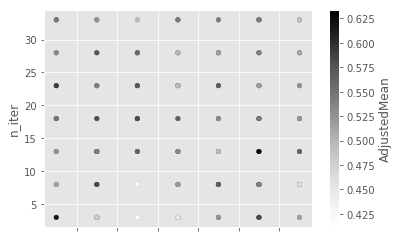

In [76]:
grid_df = pd.DataFrame(grid_svm)
grid_df['AdjustedMean'] = grid_df[['Accuracy','Specificity','Sensitivity','Precision']].mean(axis=1).values
grid_df.plot(kind='scatter',x='alpha',y='n_iter',c = 'AdjustedMean',logx=True)

best_alpha, best_n_iter, best_rnd = grid_df.sort_values('AdjustedMean',ascending = 0)[['alpha','n_iter','rand_state']].iloc[0,:]
print {'Best Alpha':best_alpha,'Best Num Iter':best_n_iter,'Best Random State':best_rnd}

### Running Multinomial Naive Bayes on Top Words

{'Sensitivity': 0.1951, 'Accuracy': 0.8309, 'Precision': 0.8, 'Specificity': 0.988}
{'Max: ': '0.910628019324', 'Mean: ': '0.831289483463', 'Min: ': '0.635265700483'}


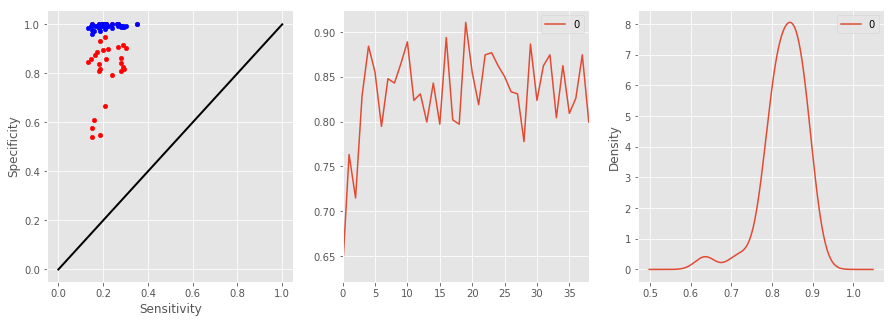

In [40]:
temp = test_clf(new_duplicate,NB,topwords,15)
print {x:round(y,4) for x,y in temp.items()}

indx = range(1,40,1)
temp1 = [test_clf(new_duplicate,NB,topwords,i) for i in indx]

CM = {'Accuracy'   :[x['Accuracy']    for x in temp1],
      'Precision'  :[x['Precision']   for x in temp1],
      'Sensitivity':[x['Sensitivity'] for x in temp1],
      'Specificity':[x['Specificity'] for x in temp1]}

_,ax = plt.subplots(1,3,figsize = [15,5])
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Precision',x = 'Sensitivity',ax=ax[0],color = 'red')
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Specificity',x = 'Sensitivity',ax=ax[0],color = 'blue')
_=ax[0].plot([0, 1], [0, 1], 'k-', lw=2)
_=pd.DataFrame(CM['Accuracy']).plot(ax=ax[1])
_=pd.DataFrame(CM['Accuracy']).plot(kind = 'kde',ax=ax[2])

print {'Min: ' : str(min(CM['Accuracy'])),
       'Max: ' : str(max(CM['Accuracy'])),
       'Mean: ' : str(np.mean(CM['Accuracy']))}

### Running SVM on Top Words

{'Sensitivity': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'Specificity': 1.0}
{'Max: ': '1.0', 'Mean: ': '0.98705561749', 'Min: ': '0.823671497585'}


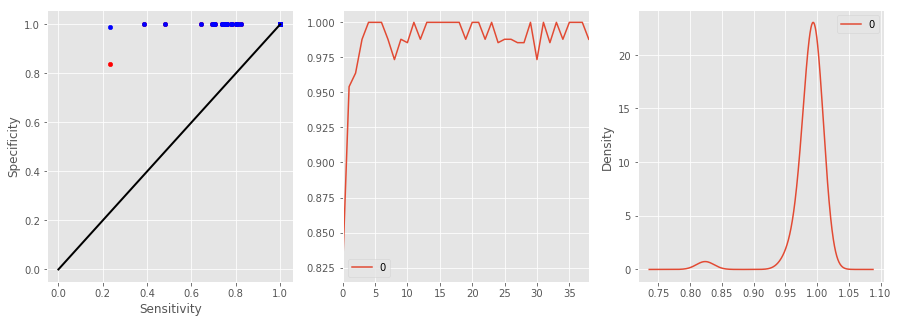

In [82]:
from sklearn.linear_model import SGDClassifier
SVM = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=best_alpha, n_iter=best_n_iter, random_state=int(best_rnd))),
                ])
svm_cm = test_clf(new_duplicate,SVM,topwords,15)
print {x:round(y,4) for x,y in svm_cm.items()}

indx = range(1,40,1)
temp1 = [test_clf(new_duplicate,SVM,topwords,i) for i in indx]

CM = {'Accuracy'   :[x['Accuracy']    for x in temp1],
      'Precision'  :[x['Precision']   for x in temp1],
      'Sensitivity':[x['Sensitivity'] for x in temp1],
      'Specificity':[x['Specificity'] for x in temp1]}

_,ax = plt.subplots(1,3,figsize = [15,5])
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Precision',x = 'Sensitivity',ax=ax[0],color = 'red')
_=pd.DataFrame(CM).plot(kind = 'scatter',y = 'Specificity',x = 'Sensitivity',ax=ax[0],color = 'blue')
_=ax[0].plot([0, 1], [0, 1], 'k-', lw=2)
_=pd.DataFrame(CM['Accuracy']).plot(ax=ax[1])
_=pd.DataFrame(CM['Accuracy']).plot(kind = 'kde',ax=ax[2])

print {'Min: ' : str(min(CM['Accuracy'])),
       'Max: ' : str(max(CM['Accuracy'])),
       'Mean: ' : str(np.mean(CM['Accuracy']))}

# ------------------------TEST-------------------------------------